In [1]:
import torch
import torch.distributions as tdist
import torch.nn as tnn
import sklearn
from sklearn.datasets import load_iris
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import pyro
import pyro.distributions as pdist
import pyro.contrib.gp as gp
import pyro.nn as pnn
import arviz
import numpy as np             
import math
import matplotlib.pyplot as plt

In [2]:
def func(X, noise_std=0.01):
    Y = -torch.sin(6*math.pi*X)**2+6*X**2-5*X**4+3/2

    noise = torch.randn_like(X) * noise_std
    return Y + noise

# Data
X = torch.tensor(np.linspace(0, 1, 30))
y = func(X)


# Use clone for splitting data and ensure requires_grad is set
X_train, X_test, y_train, y_test = train_test_split(X.clone(), y.clone(), test_size=1/3, random_state=42)

kernel = gp.kernels.Periodic(input_dim=1)

# Set the priors for the kernel parameters
kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.2, 1))  # (0.2, 1)
kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0.05, 0.3))   # (0.05, 0.3)


# Usage
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# NUTS to sample from posterior
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=2000, num_chains=2, warmup_steps=500) #tuning for warmup_steps
mcmc.run()



Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

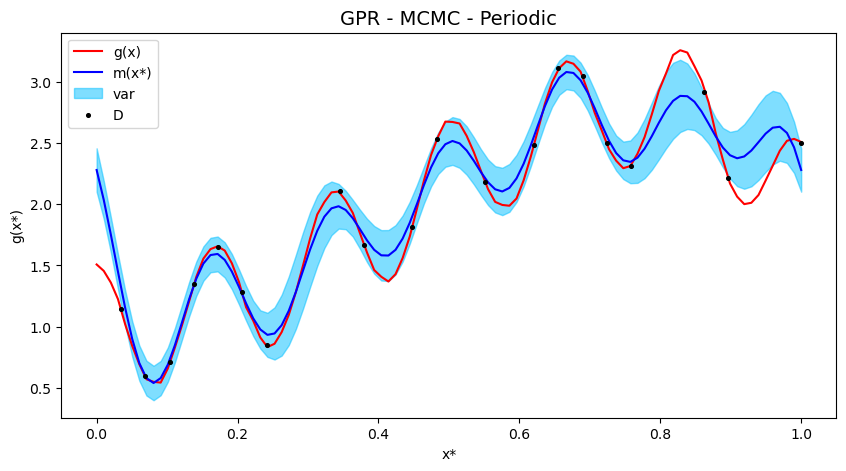

In [3]:
## estimate new point
Xnew = torch.linspace(0,1,100)
Xnew = Xnew.to(torch.double)
f_loc, f_cov = gpr(Xnew, full_cov = False)


plt.figure(figsize=(10, 5))
plt.plot(Xnew, func(Xnew),label = 'g(x)', color='red')
plt.plot(Xnew, f_loc.detach().numpy(), label='m(x*)', color='blue')
plt.fill_between(Xnew, f_loc.detach().numpy()+2*(f_cov.sqrt()).detach().numpy(), f_loc.detach().numpy()-2*(f_cov.sqrt()).detach().numpy(), color="deepskyblue", alpha=0.5,label='var')
plt.scatter(X_train,y_train,label = 'D',color='black', s=7, zorder=3)
plt.xlabel("x*")
plt.ylabel("g(x*)")
plt.title("GPR - MCMC - Periodic", fontsize=14)
plt.legend()

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.413  0.037   0.343    0.481      0.001    0.001   
kernel.variance     1.792  0.402   1.112    2.511      0.008    0.006   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale    2385.0    2213.0    1.0  
kernel.variance       2548.0    2253.0    1.0  


D:\ArcGIS Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

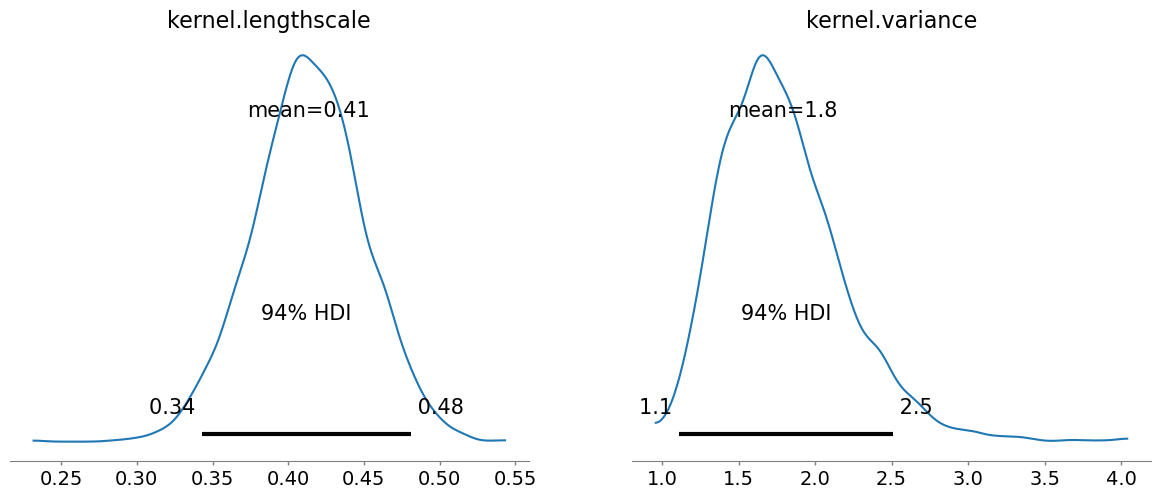

In [4]:
# diagnostics to choose hyperparameters of the sampling
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary)
arviz.plot_posterior(data)